# DESIGN THEORY

This notebook discusses how to create a transfer function for a closed loop including analysis of the resulting transfer function. The analysis focuses on first order open loop systems, open loops with a single pole and no zero.

# Preliminaries

In [1]:
try:
    import control
except:
    !pip install -q control
    import control
try:
    import controlSBML as ctl
except:
    !pip install -q controlSBML
    import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te
from typing import Optional, Tuple
ctl.__version__

'1.2.4'

# Helpers

In [2]:
TIMES = np.linspace(0, 10, 100)

In [3]:
def plotStep(tf, is_plot=True):
    """
    Plots the step response of the transfer function.

    Args:
        tf - transfer function
    """
    times, yv = control.step_response(tf)
    plt.plot(times, yv)
    if not is_plot:
        plt.close()

# TESTS
tf = control.TransferFunction([1], [1, 1])
plotStep(tf, is_plot=False)
print("OK!")

OK!


# Models

## SEQUENTIAL MODEL

Sequential reaction network

\begin{eqnarray}
S_1 & \xrightarrow{k_1 x_1} & S_2 \\
S_2 & \xrightarrow{k_2 x_2} & S_3 \\
S_3 & \xrightarrow{k_3 x_3} & \emptyset \\
\end{eqnarray}

Previously, we derived *open loop* transfer function for the sequential model.
\begin{eqnarray}
G(s) & = & \frac{X_3(s)}{X_1(s)} \\
& = & \frac{k_2 k_1 }{(s + k_3)(s + k_2)} \\
\end{eqnarray}

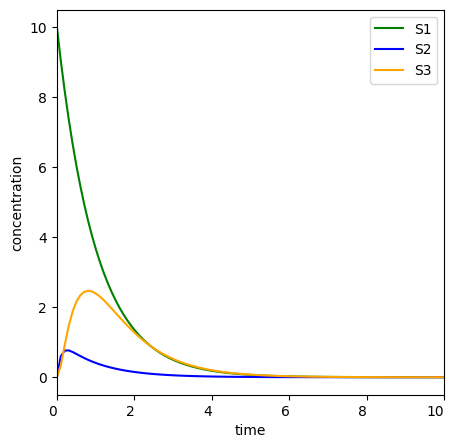

In [4]:
SEQUENTIAL_MODEL = """
model *model_main()
J1: S1 -> S2; k1*S1
J2: S2 -> S3; k2*S2
J3: S3 -> ; k3*S3
S1 = 10; S2 = 0; S3 = 0

k1 = 1
k2 = 10
k3 = 2
end
"""
SEQUENTIAL_CTLSB = ctl.ControlSBML(SEQUENTIAL_MODEL, times=TIMES,
        input_name="S1", output_name="S3")
_ = SEQUENTIAL_CTLSB.plotModel()

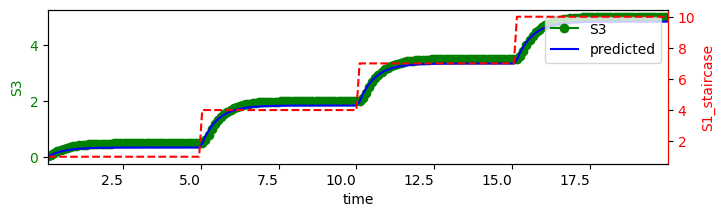


     0.498
----------------
0.4955 s + 1.001

[-2.01973723+0.j]


In [5]:
# Fit with one pole
# Fit with one pole
result = SEQUENTIAL_CTLSB.plotTransferFunctionFit(num_zero=0, num_pole=1,
            initial_value=1, final_value=10, num_step=3,
            times=np.linspace(0, 20, 200), figsize=(8, 2))
SEQUENTIAL_TF = SEQUENTIAL_CTLSB.getOpenLoopTransferFunction()
print(SEQUENTIAL_TF)
print(SEQUENTIAL_TF.poles())

## Wolf

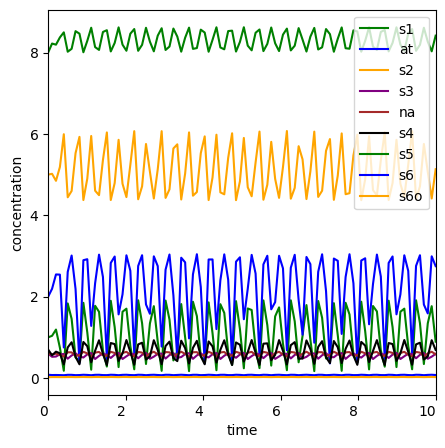

In [6]:
WOLF_CTLSB = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml",
                        input_name="s1", output_name="s5")
_ = WOLF_CTLSB.plotModel()

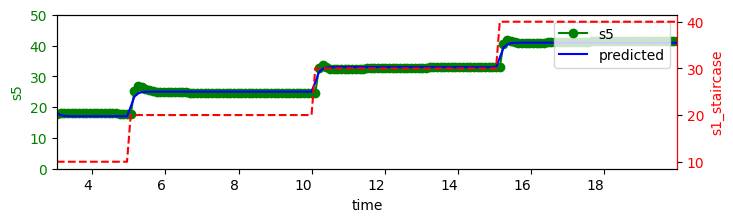


       295 s + 33.66
---------------------------
34.47 s^2 + 373.1 s + 42.48

[-10.70840432+0.j  -0.11507583+0.j]


In [7]:
result = WOLF_CTLSB.plotTransferFunctionFit(num_zero=1, num_pole=2,
            fit_start_time=3,
            initial_value=10, final_value=40, num_step=3,
            ylim=[0, 50],
            times=np.linspace(0, 20, 200), figsize=(8, 2))
WOLF_TF = WOLF_CTLSB.getOpenLoopTransferFunction()
print(WOLF_TF)
print(WOLF_TF.poles())

# Transfer Functions for PID Controller

<img src="https://raw.githubusercontent.com/joseph-hellerstein/advanced-controls-lectures/main/short_class_lectures/images/simple_feedback.png"
         alt="Types of feature extractiom."
         width="600">

The controllers considered here are systems that input the control error and produce a control signal used
to regulate the system under control.
The input signal is $e(t)$ and the output signal is $u(t)$.

## P Controller Elemental Controller

<img src="https://raw.githubusercontent.com/joseph-hellerstein/advanced-controls-lectures/main/short_class_lectures/images/P_controller.png"
         alt="Types of feature extractiom."
         width="200">

A **proportional controller** has the parameter $k_P$.
This controller outputs a signal that is proportional to the control error.
That is, for this system, the input $u(t)$ is the control error and the output $y(t)$ is the control input to the OLS.

**State and Output Equations**
1. There is no state, and so there is no state equation.
1. Output equation: $u(t) = k_P e(t)$.

**Laplace Transforms**
1. $U(s) = k_P E(s)$

**Transfer Functions**
1. $C_P(s) = \frac{U(s)}{E(s)} = k_P$

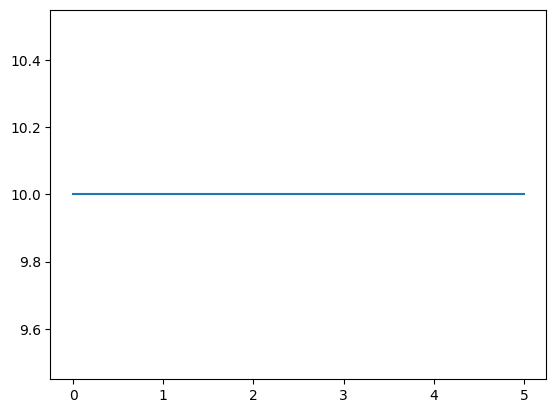

In [8]:
# Construct the transfer function
kP = 10
tf = control.TransferFunction([kP], [1])
plotStep(tf)

## I Controller Elemental Controller

<img src="https://raw.githubusercontent.com/joseph-hellerstein/advanced-controls-lectures/main/short_class_lectures/images/I_controller.png"
         alt="Types of feature extractiom."
         width="400">

An **integral controller** has the parameter $k_I$.
This controller outputs a signal that is proportional to the *integral* of the control error.
That is, $u(t) = k_I \int_0^{t} e(\tau) d \tau$.
The transfer function for this controller is $C_{I} (s) = \frac{k_I}{s}$.

**State and Output Equations**
1. The state $x(t) = \int_0^{t} e(\tau) d \tau$.
1. Output equation: $U(t) = k_I x(t)$.

**Laplace Transforms**
1. $U(s) = \frac{k_I}{s} E(s)$

**Transfer Functions**
1. $C_I(s) = \frac{U(s)}{E(s)} = \frac{k_I}{s}$

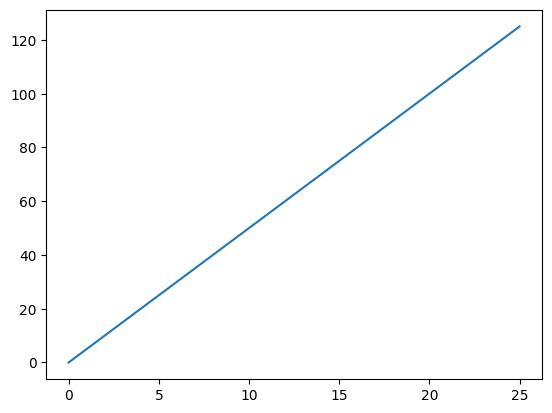

In [9]:
# Construct the transfer function
kI = 5
ci_tf = control.TransferFunction([kI], [1, 0])
plotStep(ci_tf)

## D Controller

<img src="https://raw.githubusercontent.com/joseph-hellerstein/advanced-controls-lectures/main/short_class_lectures/images/D_controller.png"
         alt="Types of feature extractiom."
         width="400">

An **differential controller** has the parameter $k_D$.
This controller outputs a signal that is proportional to the derivative of the control error.

**State and Output Equations**
1. The state $x(t) = \frac{d e(t)}{d t}$.
1. Output equation: $u(t) = k_D x(t)$.

**Laplace Transforms**
1. $U(s) = s k_D E(s)$

**Transfer Functions**
1. $C_D(s) = \frac{U(s)}{E(s)} = k_D s$

In [10]:
# Construct the transfer function
kD = 5
# The following would cause an error because the transfer function is not "proper",
# That is, the numerator degree exceeds the degree of the denominator.
tf = control.TransferFunction([kD, 0], [1])
print(tf)


5 s
---
 1



## PID Controller

<img src="https://raw.githubusercontent.com/joseph-hellerstein/advanced-controls-lectures/main/short_class_lectures/images/PID_controller.png"
         alt="Types of feature extractiom."
         width="500">

PID control is the sum of the effects of the individual controllers.

$y_{PID}(t)$ is the sum of the signals output by the P, I, and D controllers.
So, $Y_{PID}(s)$ is the sum of these signals.
That is:
\begin{eqnarray}
Y_{PID} (s) & = & Y_P(s) + Y_I (s) + Y_D (s)\\
\end{eqnarray}

* The transfer function for the P controller is $C_P(s) = \frac{U_P(s)}{E(s)}  = k_P$.
* The transfer function for  I controller is $C_I(s) = \frac{U_I(s)}{E(s)} =  \frac{k_I}{s}$.
* The transfer function for  D controller is $C_D(s) = \frac{U_D(s)}{E(s)} = k_D s$.

\begin{eqnarray}
C_{PID} (s) & = & \frac{U_{PID}(s)}{E(s)} \\
& = & \frac{U_P (s) + U_I (s) + U_D (s)}{E(s)} \\
& = & C_P (s) + C_I (s) + C_D (s) \\
& = & k_P + \frac{k_I}{s} + k_D s\\
& = & \frac{ k_I + k_P s + k_D s^2}{s} \\
\end{eqnarray}

# Closed Loop Transfer Functions

<img src="https://raw.githubusercontent.com/joseph-hellerstein/advanced-controls-lectures/main/short_class_lectures/images/simple_feedback.png"
         alt="Types of feature extractiom."
         width="600">

The starting point for transfer function analysis is to identify the system or systems to
be analyzed.
Here, we only consider single input single output (SISO) systems.
Our focus is the transfer function from the reference input to the measured output.
The desired DC gain is 1, and poles should be negative. More negative poles mean shorter settling times.

We denote this transfer function by $H(s) = \frac{Y(s)}{R(s)}$.

## Notation & definitions


| Element  | Time | Laplace  |
|--------------|--------|---------------------|
| Reference signal | $r(t)$ | $R(s)$ |
| Error signal | $e(t)$ | $E(s)$ |
| Controller System| $c(t)$ | $C(s)$ |
 | Open loop system | $g(t)$ | $G(s)$ |
 | Measured output signal | $y(t)$ | $Y(s)$|

## Derivation

\begin{eqnarray}
H(s) & = & \frac{Y(s)}{R(s)} \\
Y(s) & = & E(s)C(s)G(s) \\
E(s) & = &   R(s) - Y(s) \\
\end{eqnarray}

\begin{eqnarray}
Y(s) & = & (R(s) - Y(s))C(s)G(s) \\
 & = & R(s)C(s)G(s) - Y(s)C(s)G(s) \\
Y(s)(1 + C(s)G(s)) & = &  R(s)C(s)G(s) \\
\frac{Y(s)}{R(s)} & = & \frac{C(s)G(s)}{1 + C(s)G(s)} \\
\end{eqnarray}

## Closed loop with P-Control

For p-control, $C(s) = k_P$.

The open loop system has a first order system has the transfer function $G(s) = \frac{k}{s + p}$.

\begin{eqnarray}
H(s) & = & \frac{C(s)G(s)}{1 + C(s)G(s)} \\
& = & \frac{k_P \frac{k}{s + p}}{1 + k_P \frac{k}{s + p}} \\
& = & \frac{k_P k }{s + p + k k_P} \\
\end{eqnarray}

**Questions**
1. What are the poles of the closed loop transfer function?
1. What is the DC Gain?
1. How do settling times change as $k_P$ is increased?
1. How does DC Gain changes as $k_P$ is increased?
1. If $p < 0$ (pole is positive), can we stabilize the system with p-control?


     0.498
----------------
0.4955 s + 1.499



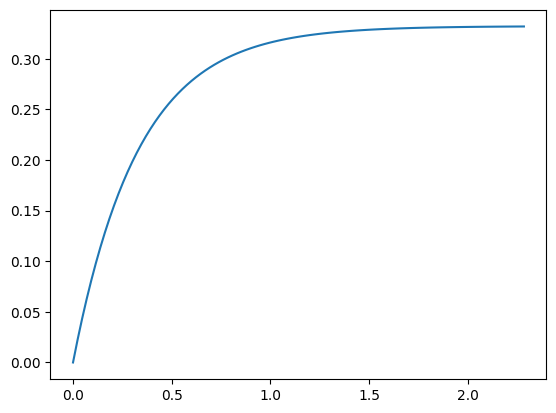

In [11]:
# Step response for SEQUENTIAL with p-control.
kp = 1
closed_tf = control.feedback(kp*SEQUENTIAL_TF)
print(closed_tf)
_ = plotStep(closed_tf)

**Questions**
1. What happens to the poles as $k_P$ increases? What happens to dcgain?
2. Why might we *not* want a larger $k_P$?

The above behaviors only apply to first order systems. Second order systems are more complicated.

## Closed loop with PI Control

<img src="https://raw.githubusercontent.com/joseph-hellerstein/advanced-controls-lectures/main/short_class_lectures/images/PI_controller.png"
         alt="Types of feature extractiom."
         width="400">

$C(s) = k_P + \frac{k_I}{s}$

The open loop system has a first order system has the transfer function $G(s) = \frac{k}{s + p}$.

\begin{eqnarray}
H(s) & = & \frac{C(s)G(s)}{1 + C(s)G(s)} \\
& = & \frac{ (k_P + \frac{k_I}{s}) \frac{k}{s + p}}{1 +  (k_P + \frac{k_I}{s}) \frac{k}{s + p}} \\
& = & \frac{kk_P s + k k_I}{s^2 + ps + kk_P s + k k_I} \\
\end{eqnarray}

We find the closed loop poles by solving the characteristic equation:
\begin{eqnarray}
0 & = & s^2 + ps + kk_P s + k k_I \\
s & = & \frac{1}{2} \left( -(p + k k_P ) \pm \sqrt{(p + k k_P)^2 - 4 k k_I} \right) \\
\end{eqnarray}

The forward loop transfer function is the product of the controller transfer function and the open loop transfer function.

In [12]:
kP = 10
kI = 1000
s = control.TransferFunction.s
c_tf = kP + kI/s
forward_tf = c_tf*SEQUENTIAL_TF
print(forward_tf)


    4.98 s + 498
--------------------
0.4955 s^2 + 1.001 s




       4.98 s + 498
--------------------------
0.4955 s^2 + 5.981 s + 498



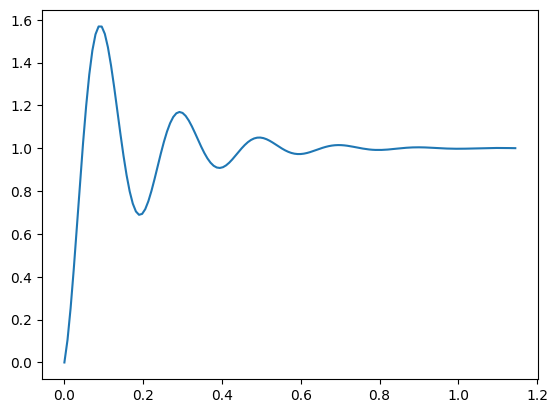

In [13]:
# Step response for SEQUENTIAL with PI-control.
closed_tf = control.feedback(forward_tf)
print(closed_tf)
plotStep(closed_tf)

**Questions**
1. What is the dcgain of $H(s)$?
2. Where are the poles if $k_P$ is large?
3. What happens if $k_I >> k_P$?
4. If $p < 0$ (pole is positive), what is needed to make the system stable?

# PI Control of WOLF Model

In [14]:
print(WOLF_TF)


       295 s + 33.66
---------------------------
34.47 s^2 + 373.1 s + 42.48




      2950 s^2 + 2.984e+04 s + 3366
-----------------------------------------
34.47 s^3 + 3323 s^2 + 2.988e+04 s + 3366



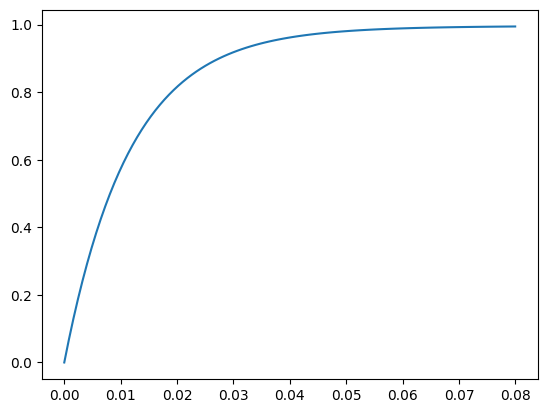

In [15]:
# Step response for WOLF with PI-control.
# forward loop TF = controller TF * WOLF_TF
kp = 10
kI = 100
s = control.TransferFunction.s
c_tf = kP + kI/s
forward_tf = c_tf*WOLF_TF
closed_tf = control.feedback(forward_tf)
print(closed_tf)
plotStep(closed_tf)